In [1]:
import numpy as np
import rebound 
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import time 

/home/naireen/anaconda2/lib/python2.7/site-packages/rebound/simulation.py:361: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/home/naireen/anaconda2/lib/python2.7/site-packages/rebound/simulation.py:361: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/home/naireen/anaconda2/lib/python2.7/site-packages/rebound/simulation.py:361: RuntimeWarning: Unknown field found in binary file.
  warnings.warn(message, RuntimeWarning)


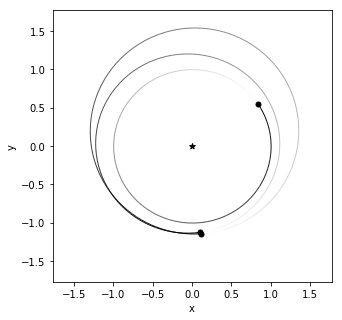

In [2]:
def plot_initial_configuration(num):
    sim = rebound.Simulation.from_file("../../csvs/Sys_2364_1e8/final_conditions/fc{:07d}.bin".format(num))
    rebound.OrbitPlot(sim)
    plt.show()
plot_initial_configuration(0)

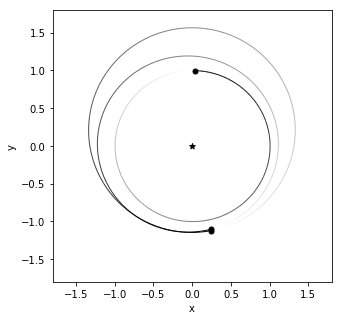

In [3]:
plot_initial_configuration(1)

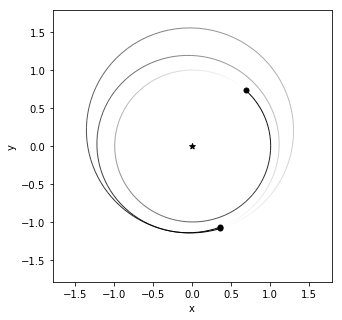

In [4]:
plot_initial_configuration(2)

In [5]:
#reintegrate some test systems, an
def collision(reb_sim, col):
    reb_sim.contents._status = 5 # causes simulation to stop running and have flag for whether sim stopped due to collision
    return 0


In [6]:
import time
from collections import OrderedDict

In [7]:
def generate_features_e_and_pomega(sim):
    t0 = time.time()
    ps = sim.particles
    
    maxorbs= 2e5
    Nout = 2000
    window = 10

    P0 = ps[1].P
    tmax = maxorbs * P0 # number of inner planet orbital periods to integrate

    sim.collision_resolve = collision

    #kicksize=1.e-11
    #sim2.particles[2].x += kicksize

    E0 = sim.calculate_energy()
    times = np.linspace(0,tmax,Nout)

    a = np.zeros((sim.N,Nout))
    e = np.zeros((sim.N,Nout))
    print e.shape, "eccentricty"
    inc = np.zeros((sim.N,Nout))

    Rhill12 = ps[1].a*((ps[1].m+ps[2].m)/3.)**(1./3.)
    Rhill23 = ps[2].a*((ps[2].m+ps[3].m)/3.)**(1./3.)

    eHill = [0, Rhill12/ps[1].a, max(Rhill12, Rhill23)/ps[2].a, Rhill23/ps[3].a]
    daOvera = [0, (ps[2].a-ps[1].a)/ps[1].a, min(ps[3].a-ps[2].a, ps[2].a-ps[1].a)/ps[2].a, (ps[3].a-ps[2].a)/ps[3].a]
    final_time = 0
    for i, t in enumerate(times):
        for j in [1,2, 3]:
            e[j,i] = ps[j].e
            inc[j,i] = ps[j].pomega
        #print("int time", t)
        try:
            sim.integrate(t)
        except:
            print "finished at ", t
            final_time = t
            break

    features = OrderedDict()
    features['t_final_short'] = sim.t/P0
    Ef = sim.calculate_energy()
    features['Rel_Eerr_short'] = abs((Ef-E0)/E0)

    t = time.time()
    features['wall_time'] = t-t0
    return pd.Series(features, index=list(features.keys())), e, final_time, inc


In [ ]:
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

(4, 2000) eccentricty
finished at  69634.7929049248
(0.0059693037323455015, 0.6025464502341495, 0.6038407618685306)


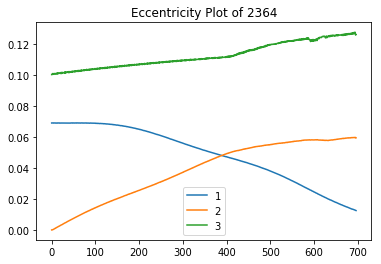

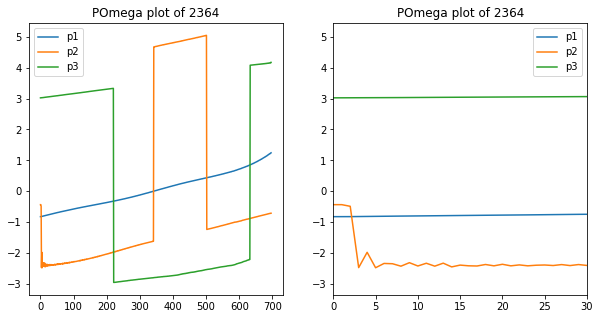

In [ ]:
def plot_e_and_pomega (num, sys_id):
    plt.figure()
    #sim = rebound.Simulation.from_file(file_path + "{:07d}.bin".format(num))
    plt.title("Eccentricity Plot of {0}".format(sys_id))
    sim = rebound.Simulation.from_file("../../csvs/Sys_{1}_1e8/initial_conditions/ic{0:07d}.bin".format(num, sys_id))
   
    values, eccen, final_time, pomega= generate_features_e_and_pomega(sim)
    e_1 = np.trim_zeros(eccen[1, :])
    e_2 = np.trim_zeros(eccen[2, :])
    e_3 = np.trim_zeros(eccen[3, :])

    p_1 = np.trim_zeros(pomega[1, :])
    p_2 = np.trim_zeros(pomega[2, :])
    p_3 = np.trim_zeros(pomega[3, :])
    
    #take the average of a moving window std of the eccentricities
    std_p1 = np.std(np.std(rolling_window(p_1, 20), 1))
    std_p2 = np.std(np.std(rolling_window(p_2, 20), 1))
    std_p3 = np.std(np.std(rolling_window(p_3, 20), 1))
    print(std_p1, std_p2, std_p3)
    
    plt.plot(e_1, label = "1")
    plt.plot(e_2, label = "2")
    plt.plot(e_3, label = "3")
    plt.legend()
    plt.show()
    
    fig =  plt.figure(figsize=(10,5))
    ax = fig.add_subplot("121")
    ax.set_title("POmega plot of {0}".format(sys_id))
    ax.plot(p_1, label = "p1")
    ax.plot(p_2, label = "p2")
    ax.plot(p_3, label = "p3")
    ax.legend()
        
    ax1 = fig.add_subplot("122")
    ax1.set_title("POmega plot of {0}".format(sys_id))
    ax1.plot(p_1, label = "p1")
    ax1.plot(p_2, label = "p2")
    ax1.plot(p_3, label = "p3")
    ax1.set_xlim([0,30])
    ax1.legend()
    plt.show()
        
    return std_p1, std_p2, std_p3
    
    #multiply x axis by 1000 for it to correspond to number of orbits
val1_bad = plot_e_and_pomega(0,2364)
plot_e_and_pomega(2,2364)

In [ ]:
#look at the other two very peaked distributions
val2_bad = plot_e_and_pomega(0,1601)
plot_e_and_pomega(2, 1601)

In [ ]:
val3_bad = plot_e_and_pomega(0,2215)
plot_e_and_pomega(2,2215)

In [ ]:
#look at the three very gaussian systems
val1_good = plot_e_and_pomega(0,1169)
plot_e_and_pomega(2,1169)

In [ ]:
val2_good = plot_e_and_pomega(0,2030)
plot_e_and_pomega(2, 2030)

In [ ]:
val3_good = plot_e_and_pomega(0,25)
vals = plot_e_and_pomega(2, 25)

In [ ]:
print val1_good, val2_good, val3_good
print val1_bad, val2_bad, val3_bad, 
x= np.arange(1, 4)
plt.scatter(x, val1_good, marker = "x", label = "1")
plt.scatter(x, val2_good, marker = "x", label = "2")
plt.scatter(x, val3_good, marker = "x", label = "3")
plt.scatter(x, val1_bad, marker = "^", label = "4")
plt.scatter(x, val2_bad, marker = "^", label = "5")
plt.scatter(x, val3_bad, marker = "^", label = "6")
plt.legend()
plt.show()